# 0-π oscillations in altermagnetic Josephson junctions

## Common imports and definitions


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bodge import *


Bad key "text.kerning_factor" on line 4 in
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Lattice construction
These functions take lattice coordinates $i, j ∈ \mathbb{N}^3$ as inputs, and for a given junction type (0º or 45º interfaces) determines whether a region is superconducting, normal metallic, or altermagnetic. Note that these functions depend on some global variables like `DIAG` and `L_SC`, which are used to alter the properties of the junctions investigated below. These variables are declared here but updated below.

In [12]:
# Whether the system has a diagonal interface.
DIAG = False

# Dimensions of the cubic lattice.
L_X = 0
L_Y = 0
L_Z = 0

# Superconductor length.
L_SC = 0 

# Normal-metal length.
L_NM = 0

# Altermagnet length.
L_AM = 0

This function calculates an "equivalent x-coordinate" for junctions with diagonal interfaces, defined as the x-coordinate at the center along the y-axis.

In [13]:
def diax(i):
    return i[0] + (i[1] - L_Y//2) * DIAG

These functions check whether a coordinate is superconducting, normal metallic, or altermagnetic.

In [20]:
def SC1(i):
    return diax(i) < L_SC
    
def SC2(i):
    return diax(i) >= L_X - L_SC

def NM1(i):
    return diax(i) < L_SC + L_NM and not SC1(i)

def NM2(i):
    return diax(i) >= L_X - L_SC - L_NM and not SC2(i)

def AM(i):
    return not SC1(i) and not SC2(i) and not NM1(i) and not NM2(i)

def probe(i):
    return diax(i) == L_SC + L_NM//2

We can also define a function for visualizing the lattices, to reduce the chance of errors. The evaluation point for currents is plotted in red.

In [24]:
def show():
    lattice = CubicLattice((L_X, L_Y, L_Z))

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()

    for i in lattice.sites():
        if SC1(i) or SC2(i):
            ax.scatter(x=i[0], y=i[1], color='#ff7f00')
        if NM1(i) or NM2(i):
            ax.scatter(x=i[0], y=i[1], color='k')
        if AM(i):
            ax.scatter(x=i[0], y=i[1], color='#984ea3')
        if probe(i):
            ax.scatter(x=i[0], y=i[1], color='#ff0000')

    plt.show()

Let's test that these work as expected by plotting one diagonal and one non-diagonal lattice.

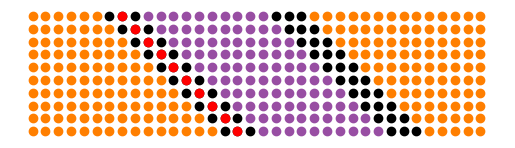

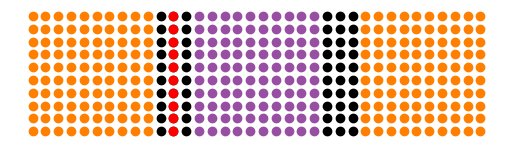

In [25]:
L_SC = 10 
L_NM = 3
L_AM = 10

L_X = 2 * L_SC + 2 * L_NM + L_AM
L_Y = 10
L_Z = 1

DIAG = True

show()

DIAG = False

show()